<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name :Armin Saghafian
### Student Number : 99105345
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [9]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
from torchsummary import summary
from torch.optim import Adam
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from copy import deepcopy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
transformation = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307],
                             std=[0.3081])
    ])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [ ]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [12]:
num_threads = 2  
batch_size  = 16   


train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_threads)
val_loader = DataLoader(dataset=valid_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_threads)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [13]:
class ResidualClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.p1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.p2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.p3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.p4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.p5 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=10),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.p1(x)
        residual1 = x
        x = self.p2(x)
        x = x + residual1
        x = self.p3(x)
        residual2 = x
        x = self.p4(x)
        x = x + residual2
        x = self.p5(x)
        return x

In [14]:
rc = ResidualClassifier()
rc.to(device)
summary(rc, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           2,320
       BatchNorm2d-6           [-1, 16, 14, 14]              32
              ReLU-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,320
       BatchNorm2d-9           [-1, 16, 14, 14]              32
             ReLU-10           [-1, 16, 14, 14]               0
        MaxPool2d-11             [-1, 16, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]           9,280
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

# Train Model (30 Points)

In [15]:
decay = 0.0001
lr = 0.001
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=decay)

In [16]:
total_step = len(train_loader)
num_epochs = 20
losses = list()
accuracies = list()
best_acc = 0
best_model = None

for epoch in range(num_epochs):

    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        predicted_targets = outputs.argmax(dim=1)
        correct += (predicted_targets == labels).sum().item()
        total += len(predicted_targets)
    
    accuracy = correct / total
    actual_loss = running_loss
    print(f'in epoch {epoch + 1} loss: {actual_loss} and accuracy: {accuracy}')
    losses.append(actual_loss)
    accuracies.append(accuracy)

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == labels).sum().item()
            total += len(predicted_targets)

        val_accuracy = correct / total
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model = deepcopy(model)
print(best_acc)

in epoch 1 loss: 1.224318027496338 and accuracy: 0.563
in epoch 2 loss: 1.015039086341858 and accuracy: 0.58644
in epoch 3 loss: 0.8800577521324158 and accuracy: 0.58872
in epoch 4 loss: 0.7206494808197021 and accuracy: 0.58964
in epoch 5 loss: 1.008421778678894 and accuracy: 0.66958
in epoch 6 loss: 0.7468236684799194 and accuracy: 0.72442
in epoch 7 loss: 0.4452967047691345 and accuracy: 0.84978
in epoch 8 loss: 0.24111053347587585 and accuracy: 0.88262
in epoch 9 loss: 0.8841100335121155 and accuracy: 0.88456
in epoch 10 loss: 0.4719030261039734 and accuracy: 0.88678
in epoch 11 loss: 1.2033631801605225 and accuracy: 0.88958
in epoch 12 loss: 0.14726370573043823 and accuracy: 0.8901
in epoch 13 loss: 0.37303462624549866 and accuracy: 0.89012
in epoch 14 loss: 0.0009119127062149346 and accuracy: 0.98468
in epoch 15 loss: 0.0020829951390624046 and accuracy: 0.99324
in epoch 16 loss: 0.0024540056474506855 and accuracy: 0.99316
in epoch 17 loss: 0.002615089062601328 and accuracy: 0.9936

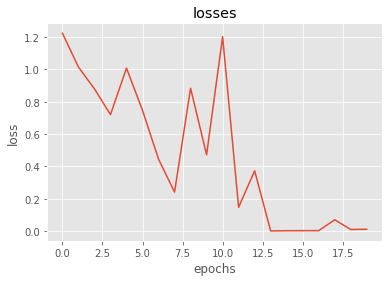

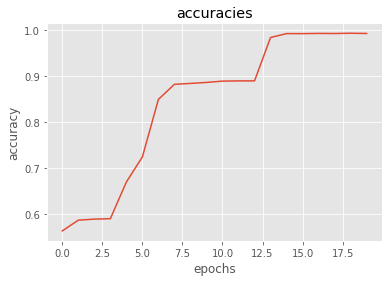

In [17]:
plt.plot(losses)
plt.title('losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.plot(accuracies)
plt.title('accuracies')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# Test Model (20 Points)

loss: 0.02330225399150513, accuracy: 0.9922
f1 score: 0.9921877548826401


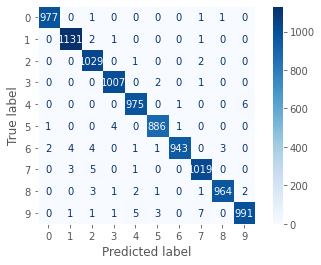

In [18]:
test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

y_true = list()
y_pred = list()
with torch.no_grad():
    best_model.eval()
    N = 0
    tot_loss, correct = 0.0, 0.0
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_model(inputs)
        N += inputs.shape[0]
        tot_loss += inputs.shape[0] * criterion(outputs, targets).item()
        predicted_targets = outputs.argmax(dim=1)
        y_true.extend(targets.cpu())
        y_pred.extend(predicted_targets.cpu())
        correct += (predicted_targets == targets).sum().item()
    res = tot_loss/N, correct/N
    print(f'loss: {res[0]}, accuracy: {res[1]}')


print(f"f1 score: {f1_score(y_true, y_pred, average='macro')}")

mt = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=mt)
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()